In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
from iris.util import broadcast_to_shape
import numpy.ma as ma
import scipy 
import cartopy.crs as ccrs
import iris.plot as iplt

In [2]:
#defining a new function for time
def make_time(start):
    
    """time = "YYYY-MM" """
    
    time = pd.period_range(start=start , periods=120, freq="M") # 10 years
    time = [datetime.datetime(i.year, i.month, 16) for i in time]
    
    return time

time_1257 = make_time("1257-01") # make a time object to plot against

In [3]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [4]:
#merging cubes without restting time 

def merge_cubes_again(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    for cube in cubes:
        new_cube = cube.copy()
        big_cube.append(new_cube)
    
    return big_cube.merge_cube()

In [5]:
#setting file path and ensemble codes
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'

coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
coupled_july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767'] 
coupled_jan = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]

In [6]:
## July ##
all_sst_july = iris.cube.CubeList()
for job_id in coupled_july:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]

    all_sst_july.append(sst_cube)

In [7]:
## Jan ##
all_sst_jan = iris.cube.CubeList()
for job_id in coupled_jan:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]

    all_sst_jan.append(sst_cube)

In [8]:
## Control ## 
all_sst_control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0]

    all_sst_control.append(sst_control)

In [9]:
#merging list of cubes into single large cube
one_big_july = merge_cubes(all_sst_july)
one_big_jan = merge_cubes(all_sst_jan)
one_big_sst_control = merge_cubes(all_sst_control)

In [10]:

mean_y1a = one_big_sst_control[:,6:18].collapsed('time',iris.analysis.MEAN)#mean control for july ensembles
mean_y1b = one_big_sst_control[:,0:12].collapsed('time',iris.analysis.MEAN)#mean control for jan ensembles

summer58jul = one_big_july[:,6:18].collapsed('time',iris.analysis.MEAN)#july 1 year post eruption
summer58jan = one_big_jan[:,0:12].collapsed('time',iris.analysis.MEAN)#jan 1 year post eruption


In [11]:
## ANOVA TEST ## 
F, p = scipy.stats.f_oneway(mean_y1a.data,summer58jul.data)

p_july = p

F, p = scipy.stats.f_oneway(mean_y1b.data,summer58jan.data)

p_jan = p

In [12]:
#taking ensemble means 
mean_control = one_big_sst_control.collapsed('realization',iris.analysis.MEAN)
mean_july = one_big_july.collapsed('realization',iris.analysis.MEAN)
mean_jan = one_big_jan.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [13]:
# calcualting anomalies
anomally_july = mean_july - mean_control.data
anomally_jan = mean_jan - mean_control.data

In [14]:
# means averaged over 1 year post eruption
july_mean = anomally_july[6:18].collapsed('time',iris.analysis.MEAN)
jan_mean = anomally_jan[0:12].collapsed('time',iris.analysis.MEAN)

In [15]:
#assigning p values to 'fake cubes' which already have lat/long data
p_data_july = july_mean.copy()
p_data_july.data = p_july

p_data_jan = jan_mean.copy()
p_data_jan.data = p_jan

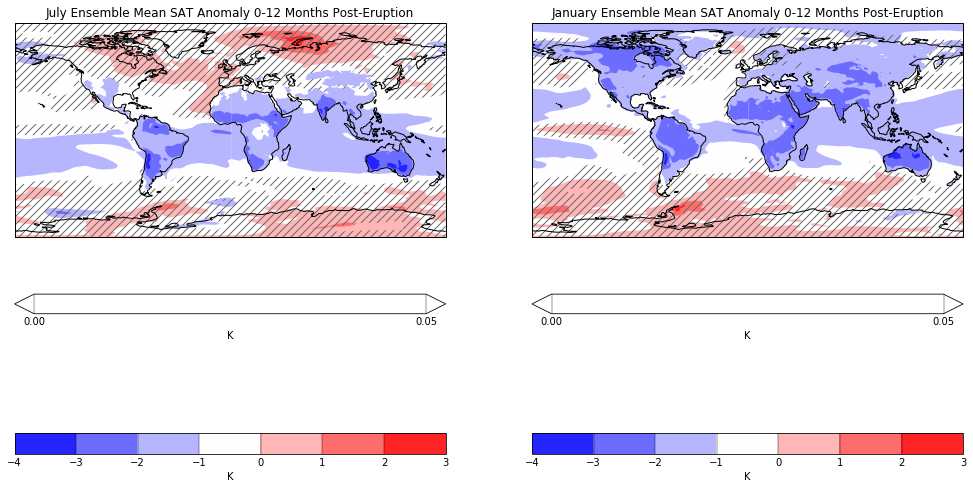

In [16]:
##July and Jan Means
levels=np.arange(-4,4,1)
plt.figure(figsize=(17,10))
mpl.rcParams['hatch.color'] = 'dimgrey'

plt.subplot(1,2,1)
qplt.contourf(july_mean, levels = levels, cmap='bwr') 
qplt.contourf(p_data_july, levels =[0,0.05], hatches =['///', None], alpha = 0, extend='both')#hashing out <95% significance
plt.gca().coastlines() # add coastlines to the plot
plt.title('July Ensemble Mean SAT Anomaly 0-12 Months Post-Eruption')

plt.subplot(1,2,2)
qplt.contourf(jan_mean, levels = levels, cmap='bwr') 
qplt.contourf(p_data_jan, levels =[0,0.05], hatches =['///', None], alpha = 0, extend='both')#hashing out <95% significance
plt.gca().coastlines() # add coastlines to the plot
plt.title('January Ensemble Mean SAT Anomaly 0-12 Months Post-Eruption')

plt.savefig('Hatched_July_Jan_Means_SAT_Y1.pdf')

In [17]:
## Loading in NTREND ##
NTREND_spatial = iris.load('ntrend2017grid.nc')#loading in data
temp_reconstruct = NTREND_spatial[0]#extracting temperature reconstructions
eruption = temp_reconstruct.extract(iris.Constraint(coord_values={'time':lambda cell: cell == 1257})) #extracting for year 1257

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u't_filtered' invalid units u'degrees_C_anomaly'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'time' invalid units u'Year CE'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'r2c' invalid units u'r2c_adj'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'CE' invalid units u'CE'
  warnin

In [18]:
#exracting just the summer of each year
july_year_anom = iris.cube.CubeList()
jul_1257 = anomally_july[4:8].collapsed('time',iris.analysis.MEAN)
jul_1258 = anomally_july[16:20].collapsed('time',iris.analysis.MEAN)
jul_1259 = anomally_july[28:32].collapsed('time',iris.analysis.MEAN)
jul_1260 = anomally_july[40:44].collapsed('time',iris.analysis.MEAN)

july_year_anom.append(jul_1257)
july_year_anom.append(jul_1258)
july_year_anom.append(jul_1259)
july_year_anom.append(jul_1260)

In [19]:
#exracting just the summer of each year
jan_year_anom = iris.cube.CubeList()
jan_1257 = anomally_jan[4:8].collapsed('time',iris.analysis.MEAN)
jan_1258 = anomally_jan[16:20].collapsed('time',iris.analysis.MEAN)
jan_1259 = anomally_jan[28:32].collapsed('time',iris.analysis.MEAN)
jan_1260 = anomally_jan[40:44].collapsed('time',iris.analysis.MEAN)

jan_year_anom.append(jan_1257)
jan_year_anom.append(jan_1258)
jan_year_anom.append(jan_1259)
jan_year_anom.append(jan_1260)

In [20]:
anomally_year_july = merge_cubes_again(july_year_anom)
anomally_year_jan = merge_cubes_again(jan_year_anom)
anomally_year_july

<iris 'Cube' of unknown / (K) (time: 4; latitude: 144; longitude: 192)>

In [21]:
## What coord system are we in? NTREND and models need to be the same
print(eruption.coord_system())
print(anomally_year_july.coord_system())

None
GeogCS(6371229.0)


In [22]:
#converting NTREND to model coord system
eruption.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis = 6371229.0)
eruption.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis = 6371229.0)


In [23]:
#guessing bounds
eruption.coord('longitude').guess_bounds()
eruption.coord('latitude').guess_bounds()

anomally_year_july.coord('longitude').guess_bounds()
anomally_year_july.coord('latitude').guess_bounds()

anomally_year_jan.coord('longitude').guess_bounds()
anomally_year_jan.coord('latitude').guess_bounds()


In [24]:
#regridding model outputs to match NTREND
regridded_july = anomally_year_july.regrid(eruption, iris.analysis.AreaWeighted(mdtol=1))
regridded_jan = anomally_year_jan.regrid(eruption, iris.analysis.AreaWeighted(mdtol=1))



In [25]:
#Creating a mask to screen out anywhwere without an NTREND value
tree_mask = np.invert(eruption.data > -2)

In [26]:
#applying mask to model outputs
regridded_july.data = ma.array(regridded_july.data, mask=broadcast_to_shape(tree_mask,regridded_july.shape,[2,1]))
regridded_jan.data = ma.array(regridded_jan.data, mask=broadcast_to_shape(tree_mask,regridded_jan.shape,[2,1]))


In [27]:
def plot_spatial_maps_blocks(anomally,eruption_name, month):

    plt.figure(figsize=(5,17))

    n=1

    for time_slice in anomally.slices(['longitude','latitude']):

        plt.subplot(5,1,n,projection=ccrs.NorthPolarStereo())
        ax=plt.gca()
        ax.set_global()

        ax.set_extent((-180, 180, 40, 90), crs=ccrs.PlateCarree())
        ax.gridlines(crs=ccrs.PlateCarree())

        iplt.pcolormesh(time_slice,cmap = plt.get_cmap('RdBu_r'),vmin=-3,vmax=3)
        ax.coastlines()
        plt.colorbar(label = 'SAT Anomally (' + u"\N{DEGREE SIGN}" + 'C)')
        plt.title(month  + ' (Summer ' + str(1257 + (n-1)) + ')')
    
        n = n+1

    plt.suptitle('SAT Yearly Anomally '+eruption_name + month + ' Ensembles')
    plt.savefig('polar_stereo_summer_yearly_sat_'+month + '.pdf')
    
    return

In [28]:
def plot_spatial_maps_blocks_levels(anomally,eruption_name, month):

    plt.figure(figsize=(10,8))

    n=1

    for time_slice in anomally.slices(['longitude','latitude']):

        plt.subplot(2,2,n,projection=ccrs.NorthPolarStereo())
        ax=plt.gca()
        ax.set_global()

        ax.set_extent((-180, 180, 40, 90), crs=ccrs.PlateCarree())
        ax.gridlines(crs=ccrs.PlateCarree())

        iplt.pcolormesh(time_slice,cmap = plt.get_cmap('RdBu_r'),vmin=-4,vmax=4)
        ax.coastlines()
        plt.colorbar(label = 'Model Run - NTREND (' + u"\N{DEGREE SIGN}" + 'C)')
        plt.title(' Year ' + str((n-1)) + ' Post-Eruption')
    
        n = n+1

    plt.suptitle('SAT Yearly Anomally '+ ' ' + eruption_name + ' ' + month + ' Ensembles')
    plt.savefig('polar_stereo_summer_yearly_sat_'+month + 'difference.pdf')
    
    return

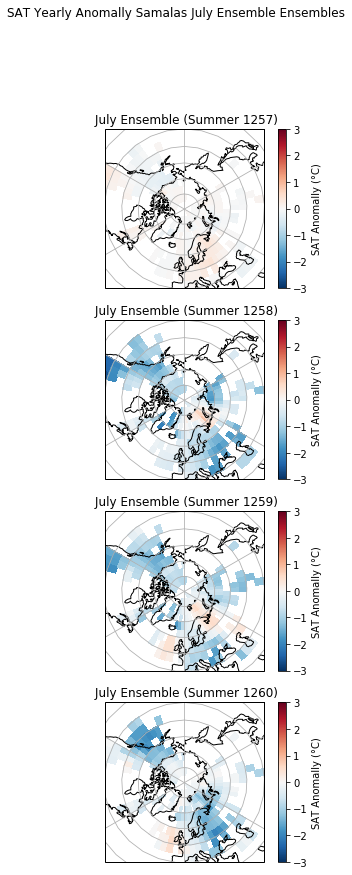

In [29]:
plot_spatial_maps_blocks(regridded_july, 'Samalas', ' July Ensemble')


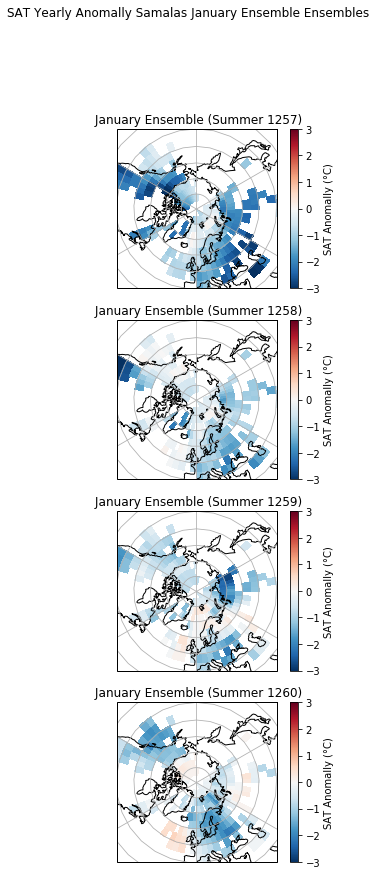

In [30]:
plot_spatial_maps_blocks(regridded_jan, 'Samalas', ' January Ensemble')


In [31]:
def extract_eruption(eruption_year):
    
    eruption = temp_reconstruct.extract(iris.Constraint(coord_values={'time':lambda cell: eruption_year-10 <= cell <= eruption_year+5})) # 5 years before, 5 years after
    
    print eruption.coord('time') # check correct years extracted
    
    avg_5_years = eruption[:,:,0:10].collapsed('time',iris.analysis.MEAN) # average the 5 years before eruption
    
    anomaly = eruption - avg_5_years # arrays are broadcast

    return anomaly[:,:,10:15] # return the four years after the eruption

In [32]:
samalas = extract_eruption(1257)

DimCoord(array([1247., 1248., 1249., 1250., 1251., 1252., 1253., 1254., 1255.,
       1256., 1257., 1258., 1259., 1260., 1261., 1262.]), standard_name='time', units=Unit('unknown'), long_name=u'Time', var_name='time', attributes={'invalid_units': u'Year CE'})


/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


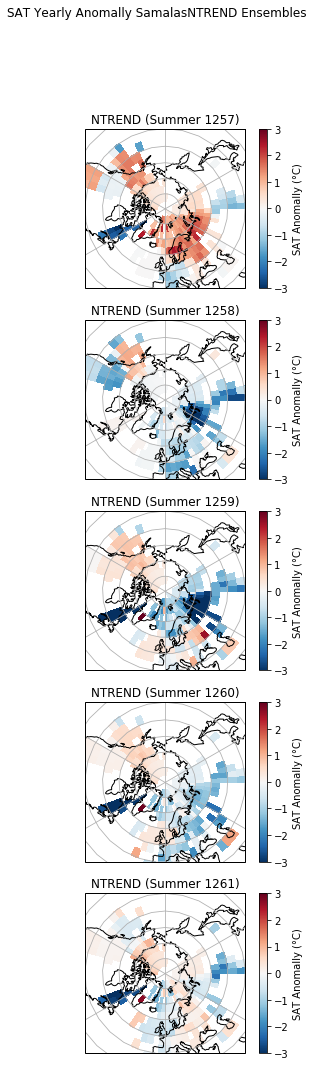

In [33]:
## Plotting NTREND for 1257-1261
plot_spatial_maps_blocks(samalas, 'Samalas', 'NTREND')